# Merging feature data
In this notebook the feature data is merged into one CSV file. The final data has a monthly rate. Data with quarterly rate was interpolated into monthly rate and the data that has daily/weekly rate was aggregated to obtain monthly rates. The end of the notebook also includes some missing data imputation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
from pathlib import Path
import re
import json

In [2]:
data_path = 'cleaned_data'
file_paths = glob.glob(data_path+'/*.csv')
file_names = os.listdir(data_path)
file_names

['car_sales.csv',
 'consumer_credits.csv',
 'consumer_price_index.csv',
 'crude_oil.csv',
 'current_account_deficit.csv',
 'export_import.csv',
 'export_unit_value_index.csv',
 'gdp.csv',
 'gold_prices.csv',
 'import_unit_value_index.csv',
 'industrial_index_codes.json',
 'industrial_production_index.csv',
 'interest_rates_mortgage.csv',
 'interest_rates_personal.csv',
 'money_supply.csv',
 'real_effective_exchange_rates.csv',
 'retail_sales.csv',
 'unemployment.csv']

In [3]:
for file_name, file_path in zip(file_names, file_paths):
    df = pd.read_csv(file_path, parse_dates=['date'])
    
    print(file_name)
    print(f"Frequency: {df['date'].diff().mean().days} days")
    print()

car_sales.csv
Frequency: 365 days

consumer_credits.csv
Frequency: 7 days

consumer_price_index.csv
Frequency: 30 days

crude_oil.csv
Frequency: 30 days

current_account_deficit.csv
Frequency: 30 days

export_import.csv
Frequency: 30 days

export_unit_value_index.csv
Frequency: 30 days

gdp.csv
Frequency: 91 days

gold_prices.csv
Frequency: 30 days

import_unit_value_index.csv
Frequency: 30 days

industrial_index_codes.json
Frequency: 30 days

industrial_production_index.csv
Frequency: 30 days

interest_rates_mortgage.csv
Frequency: 7 days

interest_rates_personal.csv
Frequency: 30 days

money_supply.csv
Frequency: 30 days

real_effective_exchange_rates.csv
Frequency: 30 days

retail_sales.csv
Frequency: 30 days



In [4]:
def interpolate_data(df):
    
    df['date'] = df['date'].dt.to_period('M')
    df = df.set_index('date').resample('M').interpolate().reset_index()
    df['date'] = df['date'].dt.to_timestamp()
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    return df

In [5]:
file_path = 'cleaned_data/gdp.csv'
df = pd.read_csv(file_path, parse_dates=['date'])
df = interpolate_data(df)
df.head()

,date,year,quarter,gdp,month
0,2005-03-01,2005,1.000000,1.425883e+08,3
1,2005-04-01,2005,1.333333,1.495625e+08,4
2,2005-05-01,2005,1.666667,1.565367e+08,5
3,2005-06-01,2005,2.000000,1.635109e+08,6
4,2005-07-01,2005,2.333333,1.712267e+08,7


In [6]:
def aggregate_data(df):
    df = df.set_index('date').resample('M').mean().reset_index()
    df['date'] = df['date'] - pd.to_timedelta(df['date'].dt.day - 1, unit='days')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    return df

In [7]:
# Aggregating data
file_path = 'cleaned_data/consumer_credits.csv'
df = pd.read_csv(file_path, parse_dates=['date'])
df = aggregate_data(df)
df.head()

,date,year,month,consumer_credits
0,2005-12-01,2005,12,28474397.00
1,2006-01-01,2006,1,29098873.75
2,2006-02-01,2006,2,30479696.75
3,2006-03-01,2006,3,32612166.20
4,2006-04-01,2006,4,35359956.00


In [8]:
def merge_data(file_paths):
    
    cols_to_drop = ['month', 'quarter', 'year']
    cols_to_drop = ['quarter', 'date']
    
    date_range = pd.date_range(start='2004-12-31', end='2019-01-01', freq='M') + pd.Timedelta('1d')
    merged_data = pd.DataFrame({'date': date_range})
    merged_data['year'] = merged_data['date'].dt.year
    merged_data['month'] = merged_data['date'].dt.month
    
    m = re.compile(r'.*\\(.+)\.csv')
    for file_path in file_paths:
        file_name = re.search(m, file_path).groups(1)[0]
        print(file_name)
        
        df = pd.read_csv(file_path, parse_dates=['date'])
        
        # Data frequency in days
        freq = df['date'].diff().mean().days
        
        if freq in range(28, 32):
            df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
            merged_data = merged_data.merge(df, how='left', on=['year', 'month'])
            
        elif freq < 27:
            df = aggregate_data(df)
            df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
            merged_data = merged_data.merge(df, how='left', on=['year', 'month'])
            
        elif 31 < freq < 300:
            df = interpolate_data(df)
            df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
            merged_data = merged_data.merge(df, how='left', on=['year', 'month'])
            
        else:
            continue
            
    return merged_data

In [65]:
df = merge_data(file_paths)

car_sales
consumer_credits
consumer_price_index
crude_oil
current_account_deficit
export_import
export_unit_value_index
gdp
gold_prices
import_unit_value_index
industrial_production_index
interest_rates_mortgage
interest_rates_personal
money_supply
real_effective_exchange_rates
retail_sales
unemployment


In [66]:
print(list(df.columns))

['date', 'year', 'month', 'consumer_credits', 'consumer_price_index', 'WTI_oil_price', 'brent_oil_price', 'current_account_deficit', 'exports_usd', 'exports_tl', 'imports_usd', 'imports_tl', 'export_unit_value_index_usd', 'export_unit_value_index_tl', 'gdp', 'gold_price_cum', 'gold_price_lon', 'import_unit_value_index_usd', 'import_unit_value_index_tl', 'B', 'B05', 'B06', 'B07', 'B08', 'B081', 'B0811', 'B0812', 'B089', 'B0891', 'B0893', 'B0899', 'B-D', 'C', 'C10', 'C101', 'C1011', 'C1012', 'C103', 'C1032', 'C1039', 'C104', 'C1041', 'C105', 'C1051', 'C106', 'C1061', 'C107', 'C1071', 'C1072', 'C108', 'C1081', 'C1082', 'C1083', 'C1089', 'C109', 'C1091', 'C1101', 'C1102', 'C1107', 'C13', 'C139', 'C1391', 'C1392', 'C1393', 'C1395', 'C1396', 'C1399', 'C14', 'C141', 'C1412', 'C1413', 'C1414', 'C1419', 'C143', 'C1431', 'C1439', 'C15', 'C151', 'C1511', 'C1512', 'C16', 'C162', 'C1621', 'C1622', 'C1623', 'C1624', 'C17', 'C172', 'C1721', 'C1722', 'C1723', 'C1729', 'C18', 'C181', 'C1811', 'C1812', 

In [67]:
missing_values = df.isna().sum().sort_values(ascending=False)
cond = missing_values > 0
print('Values missing between 2005-01-01 and 2020-01-01:\n')
print(missing_values[cond])

Values missing between 2005-01-01 and 2020-01-01:

consumer_credits    11
gdp                  2
dtype: int64


In [68]:
missing_values = df.isna().sum().sort_values(ascending=False)
cond = missing_values > 0
cols = missing_values[cond].index

print('Missing values:\n')
for col in cols:
    cond = df[col].isna()
    print(f'{col}:')
    for i, row in df.loc[cond].iterrows():
        date = row['date'].strftime('%Y-%m-%d')

        print(f'{date}')
    print()

Missing values:

consumer_credits:
2005-01-01
2005-02-01
2005-03-01
2005-04-01
2005-05-01
2005-06-01
2005-07-01
2005-08-01
2005-09-01
2005-10-01
2005-11-01

gdp:
2005-01-01
2005-02-01



### Extrapolating values
In this part the missing values of year 2005 are extrapolated from the available data

In [69]:
missing_values = df.isna().sum().sort_values(ascending=False)
cond = missing_values > 0
missing_features = missing_values[cond].index
missing_features

Index(['consumer_credits', 'gdp'], dtype='object')

#### Consumer credits data

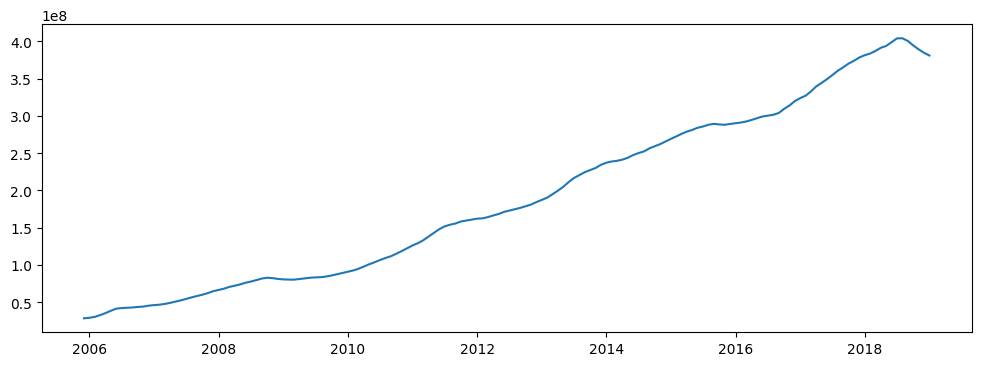

In [70]:
plt.figure(figsize=(12, 4))

y = df['consumer_credits']
x = df['date']

plt.plot(x, y)

plt.show()

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [72]:
start = 11
end = start + 3

y = df['consumer_credits'].to_numpy()[start:end]
x = df['consumer_credits'].index.to_numpy() + 1
x = np.arange(1, end+1)
x_missing = x[:start].reshape(-1, 1)
x_train = x[start:].reshape(-1, 1)

# poly = PolynomialFeatures(5)
# X_train = poly.fit_transform(x_train)
X_train = x_train

lr = LinearRegression()
lr.fit(X_train, y)

# X_missing = poly.transform(x_missing)
X_missing = x_missing
new_y = lr.predict(X_missing)

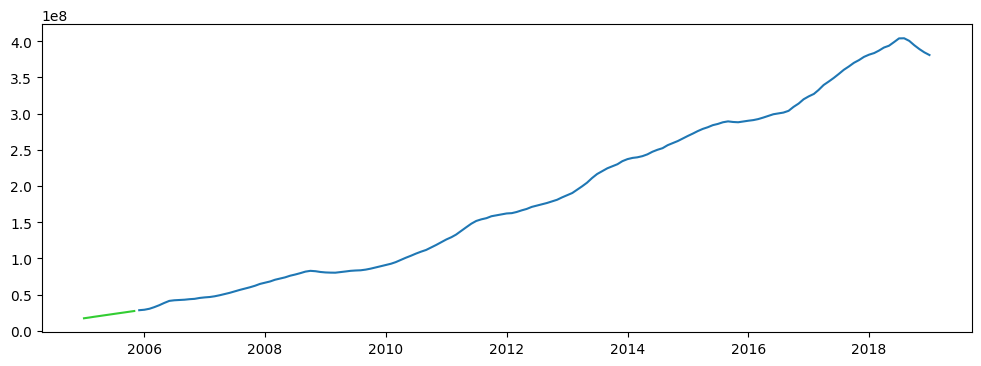

In [73]:
plt.figure(figsize=(12, 4))

y = df['consumer_credits']
x = df['date']

plt.plot(x, y)
plt.plot(x.loc[:start-1], new_y, color='limegreen')

plt.show()

In [74]:
df.loc[:10, 'consumer_credits'] = new_y

#### GDP
The first two months of 2005 are missing. Looking at the trend of the data, we notice that the GDP values tend to decrease from the first month to the third month then increase again. Based on this observation, I fit a linear regression line to the first three months of 2006 to capture the slope of this decrease. Then I updated the intercept of this model to account for the overall increasing trend. Finally, I applied the modified linear regression model on the first two months of 2005 to impute their missing values.

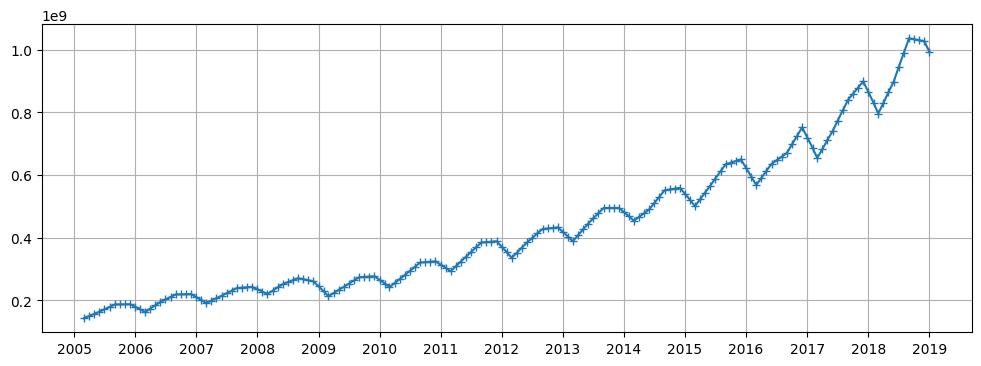

In [77]:
plt.figure(figsize=(12, 4))

# Interpolated data
plt.plot(df['date'], df['gdp'], '+-')

xticks = pd.date_range(start='2004-12-31', end='2019-01-01', freq='1y') + pd.Timedelta(days=1)
plt.xticks(xticks, labels=xticks.strftime('%Y'))
plt.grid()
plt.show()

In [78]:
# Slicing the first 3 months data from 2006
start = '2006-01-01'
end = '2006-03-01'
lr_fit_data = df.set_index('date').loc[start:end, 'gdp'].values
X = df.set_index('date').loc[start:end, 'month'].values.reshape(-1, 1)

# Fitting a linear regression model to these points
lr = LinearRegression()
lr.fit(X, lr_fit_data)

# Updating the intercept by adding the difference between 2005-03 and 2006-03 GDP values
lr.intercept_ = lr.intercept_ - lr_fit_data[-1] + df.set_index('date').loc['2005-03-01', 'gdp']

# Predicting the first two months of 2005 GDP values
predictions = lr.predict(np.array([[1], [2]]))

Plotting the imputed data

In [49]:
graph_data = df.copy()
graph_data.loc[:1, 'gdp'] = predictions

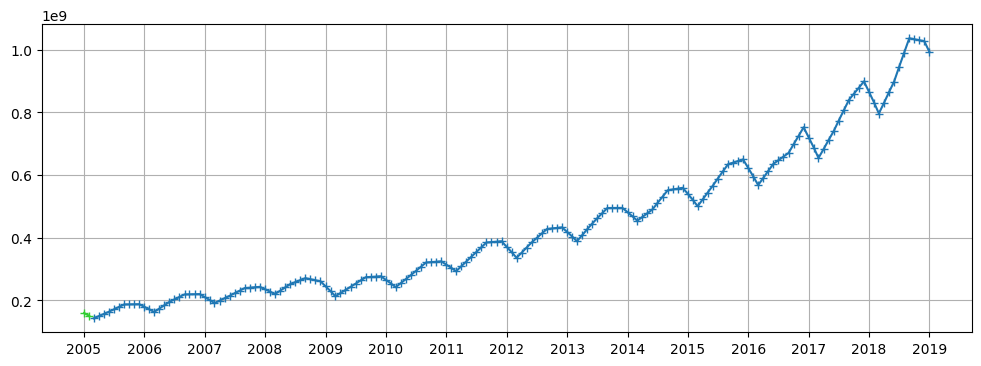

In [79]:
plt.figure(figsize=(12, 4))

plt.plot(df['date'], df['gdp'], '+-')
plt.plot(graph_data.loc[:1, 'date'], graph_data.loc[:1, 'gdp'], '+-', color='limegreen')

xticks = pd.date_range(start='2004-12-31', end='2019-01-01', freq='1y') + pd.Timedelta(days=1)
plt.xticks(xticks, labels=xticks.strftime('%Y'))
plt.grid()
plt.show()

In [80]:
# Assigning values
df.loc[:1, 'gdp'] = predictions

In [82]:
df.isna().sum().max()

0

In [83]:
# Saving the dataset
# df.to_csv('cleaned_data/merged_feature_data.csv', index=False)

In [84]:
# Loading merged feature data
df1 = pd.read_csv('cleaned_data/merged_feature_data.csv', parse_dates=['date'])